# 0-Libraries

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay, balanced_accuracy_score
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.optimizers import Adam
#from keras.backend import expand_dims
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.layers import Activation, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, SpatialDropout1D

In [53]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# 1- Load Data

In [54]:
s_aureus = pd.read_csv('s_aureus_driams_a_bin3_2000_20000Da.csv')
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19991,19994,19997,code,species,Oxacillin,Clindamycin,Ceftriaxone,Ciprofloxacin,Fusidic acid
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,35.5,20.5,27.342857,029f0abf-1664-424f-88cb-11c9c8af2b11,Staphylococcus aureus,0.0,0.0,0.0,0.0,1.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,30.0,40.5,34.695238,08149af1-10f5-4f02-81d8-3d46d66d4a7a,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,2.5,30.5,11.288462,08fe3876-ecee-4ddc-9aa9-a84f605757f7,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,15.5,8.0,20.057143,0a9fdd4b-7180-47c0-849e-cb32d46da94c,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,25.5,32.0,24.990476,0d82f4c4-473c-49d8-8c85-e3e36e96d047,Staphylococcus aureus,1.0,0.0,1.0,1.0,0.0


# Preprocessing Data

In [55]:
s_aureus_oxacillin = s_aureus.drop(columns=['code','species', 'Clindamycin', 'Ceftriaxone', 'Ciprofloxacin', 'Fusidic acid'])
s_aureus_oxacillin.dropna(axis=0, how="any", inplace=True)

In [56]:
s_aureus_ceftriaxone = s_aureus.drop(columns=['Oxacillin', 'Clindamycin', 'Ceftriaxone', 'Fusidic acid'])
#ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.shape

(3757, 6003)

In [57]:
s_aureus_oxacillin.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Oxacillin
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,14.333333,24.0,68.0,19.0,19.000000,50.0,35.5,20.5,27.342857,0.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,15.666667,39.0,19.5,42.0,69.666667,31.0,30.0,40.5,34.695238,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,20.666667,17.0,2.0,18.0,18.000000,11.5,2.5,30.5,11.288462,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,22.333333,33.0,29.0,14.5,21.666667,24.5,15.5,8.0,20.057143,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,26.666667,25.5,18.0,53.5,23.000000,24.5,25.5,32.0,24.990476,1.0


In [58]:
s_aureus_oxacillin

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Oxacillin
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,14.333333,24.0,68.0,19.0,19.000000,50.0,35.5,20.500000,27.342857,0.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,15.666667,39.0,19.5,42.0,69.666667,31.0,30.0,40.500000,34.695238,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,20.666667,17.0,2.0,18.0,18.000000,11.5,2.5,30.500000,11.288462,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,22.333333,33.0,29.0,14.5,21.666667,24.5,15.5,8.000000,20.057143,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,26.666667,25.5,18.0,53.5,23.000000,24.5,25.5,32.000000,24.990476,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3786,288.000000,330.285714,296.142857,265.142857,310.750000,287.000000,345.000000,260.000000,198.714286,257.285714,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.004038,0.0
3787,1286.142857,989.714286,938.285714,901.428571,872.000000,1001.000000,1061.571429,890.857143,813.857143,961.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.053908,0.0
3788,986.857143,977.285714,892.285714,986.714286,1045.875000,986.857143,963.571429,968.571429,960.857143,969.714286,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.039084,0.0
3789,141.857143,197.428571,148.142857,114.000000,125.857143,158.750000,176.571429,148.285714,149.714286,151.714286,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.012113,0.0


In [59]:
X = s_aureus_oxacillin.iloc[:, 0:6000].values  # variables independientes (espectros de masa)
y = s_aureus_oxacillin.iloc[:, 6000].values    # variable dependientes (resistencia a ciprofloxacin)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

## Enfoque en clase minoritaria

In [61]:
minority_class = s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].drop(columns=['Oxacillin'])


In [62]:
etiquetas = s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].iloc[:, 6000].values

Diffusion model


In [63]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [64]:
torch.manual_seed(42)
np.random.seed(42)

In [65]:
# Preprocesamiento
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train)

In [66]:
# Modelo de Difusión
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Regularización Dropout
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Regularización Dropout
            nn.Linear(32, input_dim)
        )


    def forward(self, x):
        return self.model(x)


In [67]:
# Función de ruido (Scheduler)
def add_noise(data, timesteps, noise_scale=1.0):
    noise = np.random.normal(0, noise_scale, data.shape) * np.sqrt(timesteps / 100)
    noisy_data = data + noise
    return noisy_data, noise


In [68]:
# Configuración del modelo
input_dim = scaled_data.shape[1]
model = DiffusionModel(input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.SmoothL1Loss()  # O Huber Loss


In [69]:
# Scheduler de tasa de aprendizaje
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)


In [70]:
# Entrenamiento
scaled_data_tensor = torch.tensor(scaled_data, dtype=torch.float32)
epochs = 500
losses = []  # Para guardar la pérdida por época

for epoch in range(epochs):
    timesteps = np.random.randint(1, 100)
    noisy_data, noise = add_noise(scaled_data, timesteps)
    noisy_data_tensor = torch.tensor(noisy_data, dtype=torch.float32)
    noise_tensor = torch.tensor(noise, dtype=torch.float32)

    optimizer.zero_grad()
    predicted_noise = model(noisy_data_tensor)
    loss = loss_fn(predicted_noise, noise_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()  # Actualiza la tasa de aprendizaje

    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.item()}")


Epoch 0/500 - Loss: 0.2571299076080322
Epoch 100/500 - Loss: 0.3130102753639221
Epoch 200/500 - Loss: 0.24004623293876648
Epoch 300/500 - Loss: 0.36852067708969116
Epoch 400/500 - Loss: 0.16111202538013458


In [71]:
# Generación de Datos Sintéticos
def generate_synthetic_data(model, num_samples, input_dim):
    model.eval()
    with torch.no_grad():
        synthetic_data = np.random.normal(0, 1, (num_samples, input_dim))
        for t in range(100, 0, -1):  # Reverse diffusion
            synthetic_data = synthetic_data - model(torch.tensor(synthetic_data, dtype=torch.float32)).numpy() * (t / 100)
        return synthetic_data

In [72]:
print(pd.Series(y_train).value_counts())

0.0    2451
1.0     581
Name: count, dtype: int64


In [73]:
pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1]

1870

In [74]:

synthetic_data = generate_synthetic_data(model, pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1], input_dim)
synthetic_data_rescaled = scaler.inverse_transform(synthetic_data)


In [75]:
synthetic_data_rescaled.shape

(1870, 6000)

In [76]:

# Cambiar el tipo de datos a float32
synthetic_samples_numpy = synthetic_data_rescaled.astype(np.float32)

# Mostrar las muestras generadas
synthetic_samples_numpy.shape

(1870, 6000)

In [77]:
X_train_resampled = np.concatenate([X_train,synthetic_samples_numpy])

In [78]:
X_train_resampled.shape

(4902, 6000)

In [79]:
ones_array = np.ones(pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1])
y_train_resampled = np.concatenate([y_train,ones_array])
y_train_resampled.shape

(4902,)

## Termino oversampling

In [80]:
scaler=Normalizer(norm='max')
sc_X = scaler
X_train = sc_X.fit_transform(X_train_resampled)
X_test = sc_X.transform(X_test)

In [81]:
sample_size = X_train.shape[0] # numero de muestras en el set de datos
time_steps  = X_train.shape[1] # numero de atributos en el set de datos
input_dimension = 1            #

X_train_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [82]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
early_st = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

n_timesteps = X_train_reshaped.shape[1] #
n_features  = X_train_reshaped.shape[2] #

In [83]:
print(pd.Series(y_train_resampled).value_counts())


1.0    2451
0.0    2451
Name: count, dtype: int64


# Create and fit DeepAMR model

In [84]:
model = Sequential(name="Modelo_s_aureus_ciprofloxacin")
init_mode = 'normal'
model.add(Conv1D(filters=(64), kernel_size=(17), input_shape = (n_timesteps,n_features), name='Conv_1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_1"))

model.add(Conv1D(filters=(128), kernel_size=(9),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name='Conv_2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_2"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode,kernel_regularizer=regularizers.l2(0.0001),   name='Conv_3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_3"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),   name='Conv_4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_4"))

model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(256, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_0"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_1"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name="fully_connected_2"))
model.add(Dense(n_features, activation='sigmoid', name="OUT_Layer"))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',  metrics=METRICS)
model.summary()

Model: "Modelo_s_aureus_ciprofloxacin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv1D)             (None, 5984, 64)          1152      
                                                                 
 batch_normalization_4 (Batc  (None, 5984, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 5984, 64)          0         
                                                                 
 MaxPooling1D_1 (MaxPooling1  (None, 2992, 64)         0         
 D)                                                              
                                                                 
 Conv_2 (Conv1D)             (None, 2984, 128)         73856     
                                                                 
 batch_normalization_5 (Batc  (None, 

In [85]:
history = model.fit(X_train_reshaped, y_train_resampled, epochs=200, batch_size=10, verbose=1, validation_split=0.1, callbacks=[reduce_lr,early_st])

Epoch 1/200
442/442 [==============================] - 13s 26ms/step - loss: 5.9695 - tp: 1417.0000 - fp: 145.0000 - tn: 2306.0000 - fn: 543.0000 - accuracy: 0.8440 - precision: 0.9072 - recall: 0.7230 - auc: 0.8724 - prc: 0.8984 - val_loss: 6.3356 - val_tp: 6.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 485.0000 - val_accuracy: 0.0122 - val_precision: 1.0000 - val_recall: 0.0122 - val_auc: 0.0000e+00 - val_prc: 1.0000 - lr: 1.0000e-04
Epoch 2/200
442/442 [==============================] - 11s 24ms/step - loss: 5.1382 - tp: 1439.0000 - fp: 72.0000 - tn: 2379.0000 - fn: 521.0000 - accuracy: 0.8656 - precision: 0.9523 - recall: 0.7342 - auc: 0.8971 - prc: 0.9151 - val_loss: 4.5206 - val_tp: 491.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 0.0000e+00 - val_prc: 1.0000 - lr: 1.0000e-04
Epoch 3/200
442/442 [==============================] - 10s 23ms/step - loss: 4.5674 - tp: 148

# Evaluate the model

In [86]:
y_pred  = model.predict(X_test_reshaped)
y_pred = (y_pred>0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)

24/24 [==============================] - 1s 11ms/step
[[589  24]
 [ 48  97]]


In [87]:
print("balanced acuracy:", balanced_accuracy_score(y_test, y_pred))

balanced acuracy: 0.8149069021769703


In [88]:
target_names=["0","1"]
print(classification_report(y_test, y_pred, target_names=target_names))

train_predictions_baseline = model.predict(X_train_reshaped, batch_size=10)
test_predictions_baseline = model.predict(X_test_reshaped, batch_size=10)

baseline_results = model.evaluate(X_test_reshaped, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       613
           1       0.80      0.67      0.73       145

    accuracy                           0.91       758
   macro avg       0.86      0.81      0.84       758
weighted avg       0.90      0.91      0.90       758

76/76 [==============================] - 1s 6ms/step
loss :  0.4929445683956146
tp :  97.0
fp :  24.0
tn :  589.0
fn :  48.0
accuracy :  0.9050132036209106
precision :  0.8016529083251953
recall :  0.6689655184745789
auc :  0.9052202701568604
prc :  0.8146541714668274



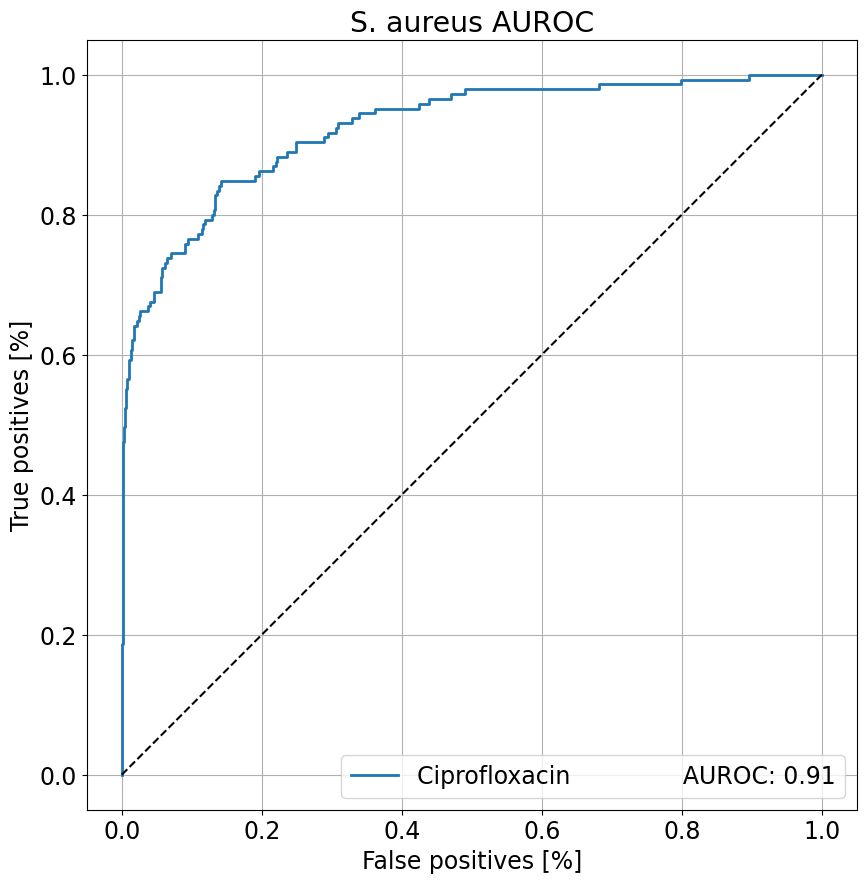

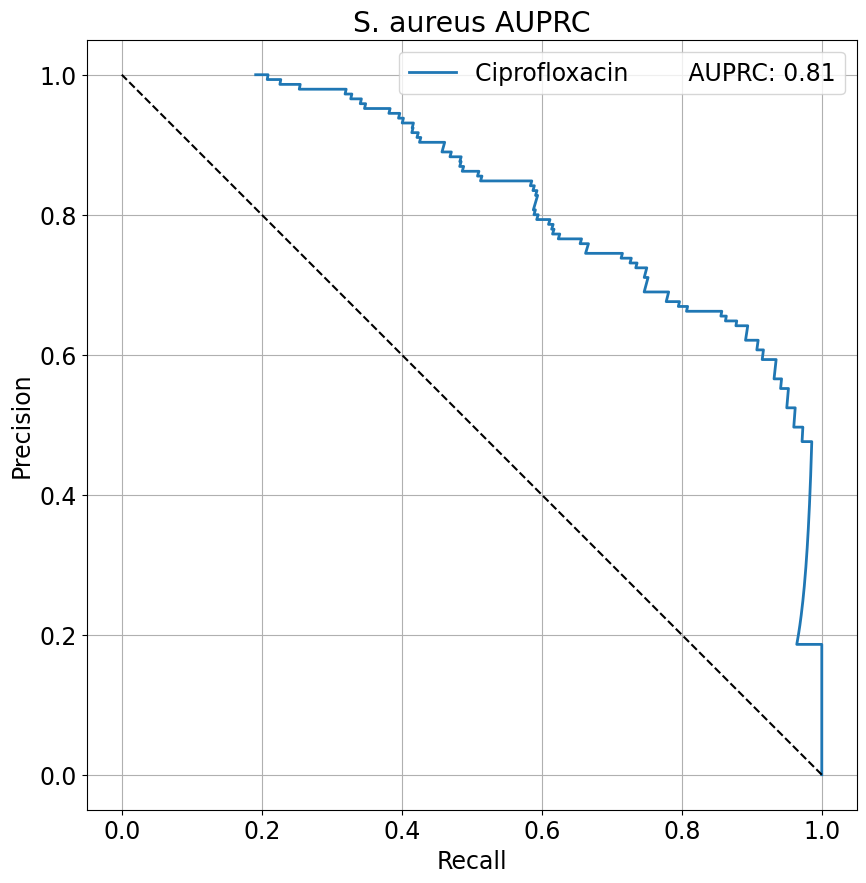

In [89]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams.update({'font.size': 17})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('E. coli CNN')
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('S. aureus AUROC')

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Ciprofloxacin               AUROC: %0.2f" % baseline_results[8], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='lower right')
plt.savefig('s_aureus_auroc.png', bbox_inches='tight')
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('S. aureus AUPRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([1, 0], [0, 1], 'k--')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Ciprofloxacin        AUPRC: %0.2f" % baseline_results[9], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='upper right')
plt.savefig('s_aureus_auprc.png', bbox_inches='tight')
plt.show()